GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 2152 images belonging to 2 classes.
Found 537 images belonging to 2 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730726643.480392      87 service.cc:145] XLA service 0x7fabb4003730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730726643.480452      87 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/68 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5469 - loss: 12.3288  

I0000 00:00:1730726652.988612      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 73s 809ms/step - accuracy: 0.7120 - loss: 11.6421 - val_accuracy: 0.8641 - val_loss: 9.8650 - learning_rate: 1.0000e-04
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 570ms/step - accuracy: 0.8914 - loss: 9.3575 - val_accuracy: 0.8659 - val_loss: 8.0647 - learning_rate: 1.0000e-04
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 560ms/step - accuracy: 0.9177 - loss: 7.5958 - val_accuracy: 0.8976 - val_loss: 6.5707 - learning_rate: 1.0000e-04
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 562ms/step - accuracy: 0.9431 - loss: 6.1568 - val_accuracy: 0.8827 - val_loss: 5.3983 - learning_rate: 1.0000e-04
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 567ms/step - accuracy: 0.9210 - loss: 5.0661 - val_accuracy: 0.8994 - val_loss: 4.4372 - learning_rate: 1.0000e-04
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 562ms/step - accuracy: 0.9457 - loss: 4.1351 - val_accuracy: 0.8864 - val_loss: 3.6866 - learning_rate: 1.0000e-04
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 550ms/step - accuracy: 0.9

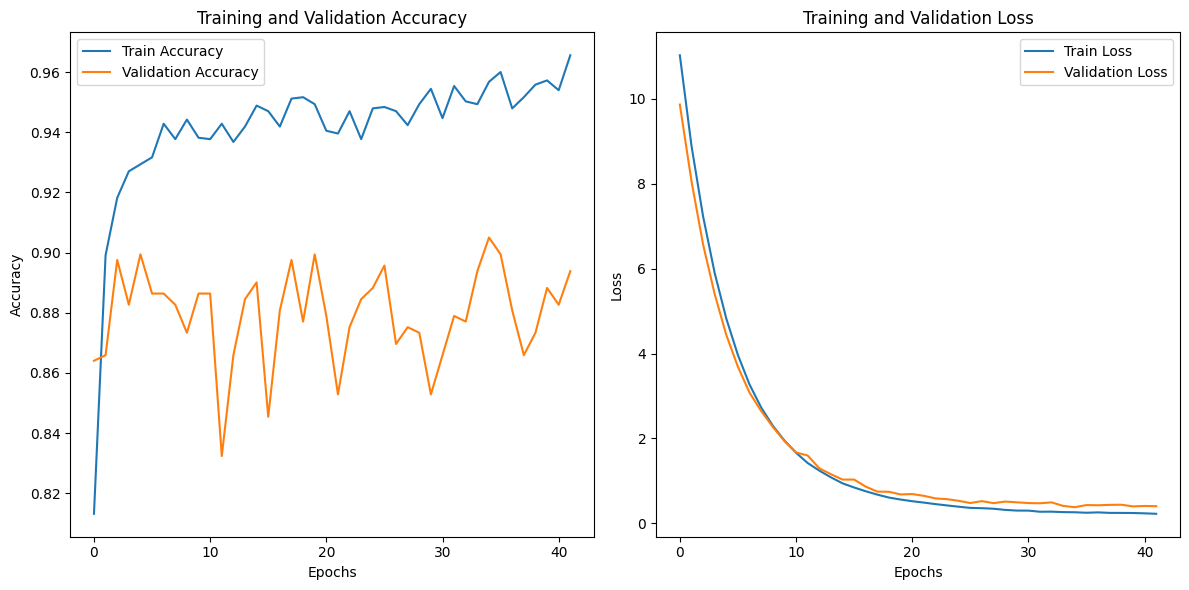

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 485ms/step - accuracy: 0.8891 - loss: 0.4421

Test Accuracy for Xception: 0.9088


In [ ]:
# Step 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Check if GPU is being used
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Step 2: Data Preprocessing and Augmentation (enhanced)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Define training and validation data generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/waste-custom-data/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/waste-custom-data/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Step 3: Define the Xception model with hyperparameter tuning
def create_xception_model():
    base_model = tf.keras.applications.Xception(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.4),  # Increased dropout for regularization
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),  # Additional dropout layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Use a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Step 4: Train the Xception model with tuned hyperparameters
xception_model = create_xception_model()

# Set up callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = xception_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Step 5: Plot training and validation accuracy/loss for analysis
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 6: Evaluate the model performance on the validation set
test_loss, test_acc = xception_model.evaluate(validation_generator)
print(f'\nTest Accuracy for Xception: {test_acc:.4f}')

# Step 7: Convert the Keras model to TFLite
# Save the trained model first
xception_model.save('xception_model.h5')

# Load the saved model for conversion
model = tf.keras.models.load_model('xception_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('xception_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite format and saved as 'xception_model.tflite'.")

# Optional: Enable optimizations for the TFLite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert and save the optimized TFLite model
tflite_model_optimized = converter.convert()

with open('xception_model_optimized.tflite', 'wb') as f:
    f.write(tflite_model_optimized)

print("Optimized TFLite model saved as 'xception_model_optimized.tflite'.")


In [ ]:
import tensorflow as tf
# Load the saved model for conversion
model = tf.keras.models.load_model('xception_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('xception_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite format and saved as 'xception_model.tflite'.")

# Optional: Enable optimizations for the TFLite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert and save the optimized TFLite model
tflite_model_optimized = converter.convert()

with open('xception_model_optimized.tflite', 'wb') as f:
    f.write(tflite_model_optimized)

print("Optimized TFLite model saved as 'xception_model_optimized.tflite'.")


In [ ]:
import tensorflow as tf
import os

# Load the saved model for conversion
try:
    model = tf.keras.models.load_model('xception_model.h5')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise  # Stop execution if model loading fails

# Attempt conversion without optimizations first
try:
    print("Starting model conversion to TFLite without optimizations...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    print("Model successfully converted to TensorFlow Lite format without optimizations.")

    # Save the TFLite model
    with open('xception_model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("Model successfully saved as 'xception_model.tflite'.")

except Exception as e:
    print(f"Error during TFLite conversion: {e}")

# If the above succeeds, attempt conversion with optimizations
try:
    print("Starting model conversion to TFLite with quantization...")
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model_optimized = converter.convert()
    
    # Save the optimized TFLite model
    with open('xception_model_optimized.tflite', 'wb') as f:
        f.write(tflite_model_optimized)
    print("Optimized model successfully saved as 'xception_model_optimized.tflite'.")

except Exception as e:
    print(f"Error during optimized TFLite conversion: {e}")


Model loaded successfully.
Starting model conversion to TFLite without optimizations...


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 2152 images belonging to 2 classes.
Found 537 images belonging to 2 classes.
Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 583ms/step - accuracy: 0.7374 - loss: 11.6303 - val_accuracy: 0.8901 - val_loss: 9.8368 - learning_rate: 1.0000e-04
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 475ms/step - accuracy: 0.9089 - loss: 9.3696 - val_accuracy: 0.8790 - val_loss: 8.0567 - learning_rate: 1.0000e-04
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 474ms/step - accuracy: 0.9095 - loss: 7.6092 - val_accuracy: 0.8734 - val_loss: 6.5721 - learning_rate: 1.0000e-04
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 461ms/step - accuracy: 0.9214 - loss: 6.1876 - val_accuracy: 0.8845 - val_loss: 5.3769 - learning_rate: 1.0000e-04
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9268 - loss: 5.0656 - val_accuracy: 0.8883 - val_loss: 4.4310 - learning_rate: 1.0000e-04
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/

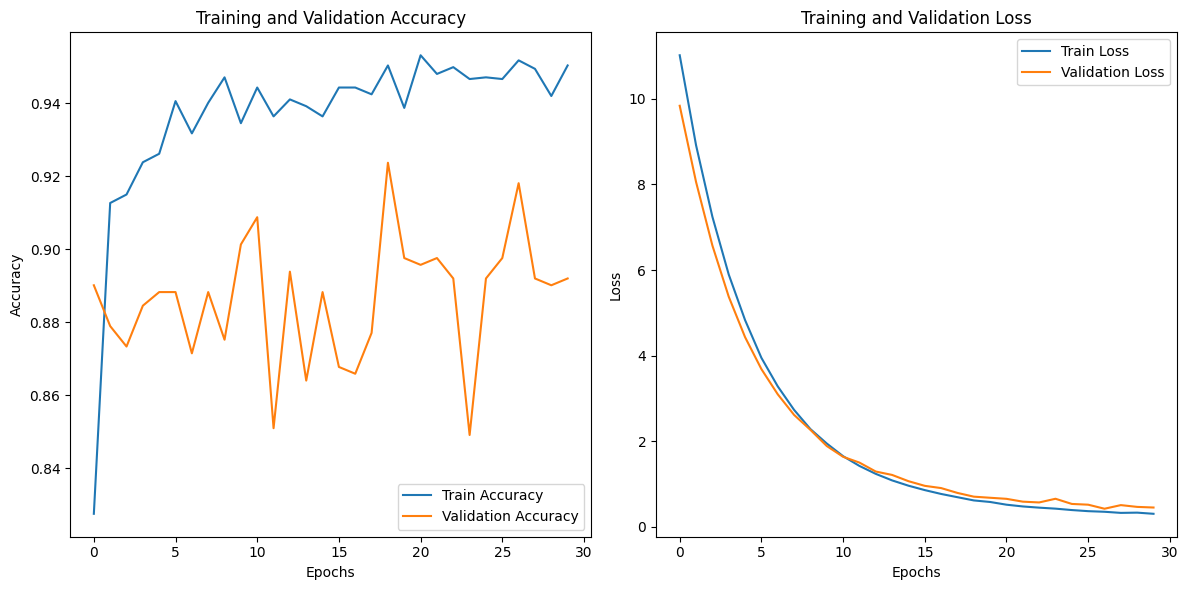

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step - accuracy: 0.8991 - loss: 0.4497

Test Accuracy for Xception: 0.8920
Error loading model: [Errno 2] Unable to synchronously open file (unable to open file: name = 'xception_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Starting model conversion to TFLite...
Error during model conversion: name 'model' is not defined


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 1: Check if GPU is being used
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Step 2: Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Define training and validation data generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/waste-custom-data/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/waste-custom-data/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Step 3: Define the Xception model using the Functional API
def create_xception_model():
    base_model = tf.keras.applications.Xception(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.4)(x)  # Increased dropout for regularization
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)  # Additional dropout layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Step 4: Train the Xception model
xception_model = create_xception_model()

# Set up callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = xception_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Step 5: Plot training and validation accuracy/loss for analysis
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 6: Evaluate the model performance on the validation set
test_loss, test_acc = xception_model.evaluate(validation_generator)
print(f'\nTest Accuracy for Xception: {test_acc:.4f}')

# Step 7: Save the trained model
xception_model.save('xception_modelv2.h5')

# Step 8: Load the saved model for conversion
try:
    model = tf.keras.models.load_model('xception_model.h5')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Step 9: Convert the model to TensorFlow Lite format
try:
    print("Starting model conversion to TFLite...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TFLite model
    with open('xception_model.tflite', 'wb') as f:
        f.write(tflite_model)

    print("Model successfully converted to TensorFlow Lite format and saved as 'xception_model.tflite'.")

    # Optional: Enable optimizations for the TFLite model
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Convert and save the optimized TFLite model
    tflite_model_optimized = converter.convert()

    with open('xception_model_optimized.tflite', 'wb') as f:
        f.write(tflite_model_optimized)

    print("Optimized TFLite model saved as 'xception_model_optimized.tflite'.")
except Exception as e:
    print(f"Error during model conversion: {e}")


In [ ]:
# Step 8: Load the saved model for conversion
try:
    model = tf.keras.models.load_model('/kaggle/working/xception_modelv2.h5')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Step 9: Convert the model to TensorFlow Lite format
try:
    print("Starting model conversion to TFLite...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TFLite model
    with open('xception_model.tflite', 'wb') as f:
        f.write(tflite_model)

    print("Model successfully converted to TensorFlow Lite format and saved as 'xception_model.tflite'.")

    # Optional: Enable optimizations for the TFLite model
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Convert and save the optimized TFLite model
    tflite_model_optimized = converter.convert()

    with open('xception_model_optimized.tflite', 'wb') as f:
        f.write(tflite_model_optimized)

    print("Optimized TFLite model saved as 'xception_model_optimized.tflite'.")
except Exception as e:
    print(f"Error during model conversion: {e}")


Model loaded successfully.
Starting model conversion to TFLite...


Found 537 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731412654.935577     117 service.cc:145] XLA service 0x7fad50001620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731412654.935648     117 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:57 7s/step

I0000 00:00:1731412660.372863     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 733ms/step
Classification Report:
                   precision    recall  f1-score   support

Non-Biodegradable       0.89      0.84      0.86       228
    Biodegradable       0.89      0.93      0.91       309

         accuracy                           0.89       537
        macro avg       0.89      0.88      0.88       537
     weighted avg       0.89      0.89      0.89       537



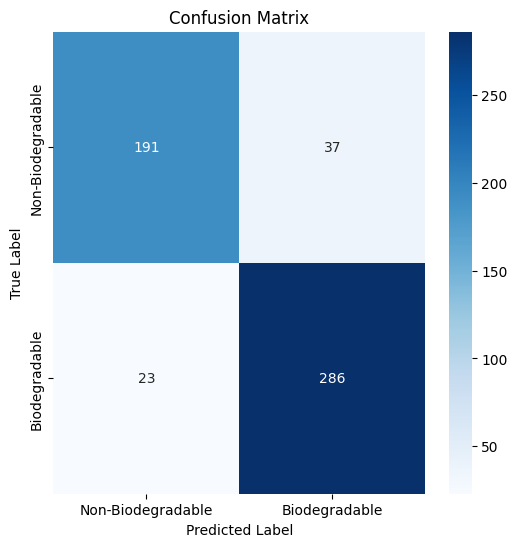

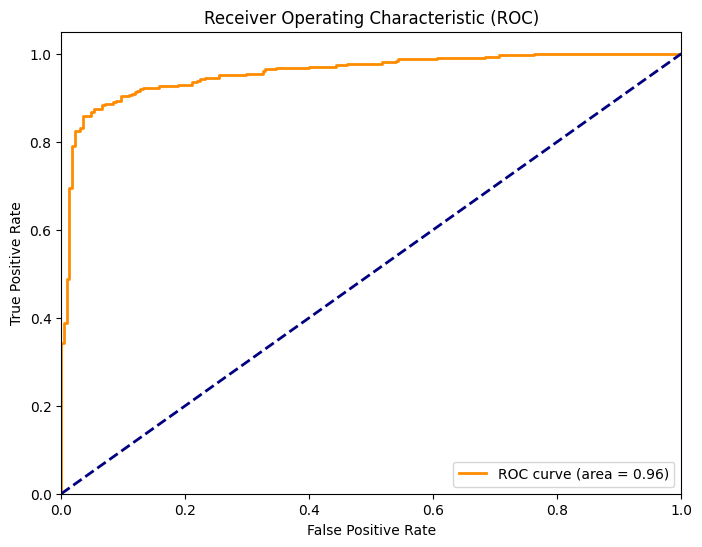

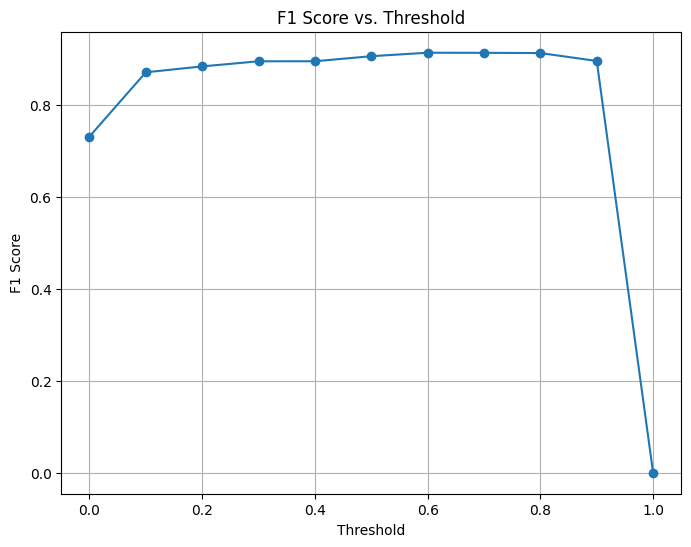

In [4]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the saved Keras model (.h5 file)
mp = '/kaggle/input/xception_model/keras/default/1/xception_modelv2.h5'
model = tf.keras.models.load_model(mp)


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 2: Data Preprocessing and Augmentation (enhanced)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


# Step 2: Prepare the data (use the same validation generator from your original notebook)
validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/waste-custom-data/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False  # Ensure that the order of predictions matches the true labels
)

# Step 3: Generate predictions using the loaded model
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.round(y_pred_probs)  # Convert probabilities to binary predictions (0 or 1)

# Step 4: Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Biodegradable', 'Biodegradable']))

# Step 5: Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Biodegradable', 'Biodegradable'], yticklabels=['Non-Biodegradable', 'Biodegradable'])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 6: ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Step 7: F1 Score vs Threshold Curve
thresholds = np.arange(0.0, 1.1, 0.1)
f1_scores = [f1_score(y_true, (y_pred_probs > thresh).astype(int)) for thresh in thresholds]

# Plot F1 score curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [ ]:
# Step 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Check if GPU is being used
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Step 2: Data Preprocessing and Augmentation (enhanced)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Define training and validation data generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/waste-custom-data/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/waste-custom-data/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Step 3: Define the Xception model with hyperparameter tuning
def create_xception_model():
    base_model = tf.keras.applications.Xception(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.4),  # Increased dropout for regularization
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.3),  # Additional dropout layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Use a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Step 4: Train the Xception model with tuned hyperparameters
xception_model = create_xception_model()

# Set up callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = xception_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Step 5: Plot training accuracy and loss for analysis
plt.figure(figsize=(12, 6))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 6: Evaluate the model performance on the validation set
test_loss, test_acc = xception_model.evaluate(validation_generator)
print(f'\nTest Accuracy for Xception: {test_acc:.4f}')


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 2152 images belonging to 2 classes.
Found 537 images belonging to 2 classes.
Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 532ms/step - accuracy: 0.7469 - loss: 11.6355 - val_accuracy: 0.8845 - val_loss: 9.8519 - learning_rate: 1.0000e-04
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 438ms/step - accuracy: 0.9083 - loss: 9.3581 - val_accuracy: 0.8957 - val_loss: 8.0101 - learning_rate: 1.0000e-04
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 443ms/step - accuracy: 0.9099 - loss: 7.6135 - val_accuracy: 0.8734 - val_loss: 6.5824 - learning_rate: 1.0000e-04
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.9251 - loss: 6.1713 - val_accuracy: 0.8734 - val_loss: 5.4088 - learning_rate: 1.0000e-04
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - accuracy: 0.9355 - loss: 5.0354 - val_accuracy: 0.8547 - val_loss: 4.4765 - learning_rate: 1.0000e-04
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 441ms/